# DOWNLOAD


In [ ]:
"""
Created on Mon Sep  7 12:06:03 2020

@author: alessio arcudi, alessandro mazzoni, alessandro padella
"""

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
This script exploit the packet pytube and keras video in order to
download and organize video from youtube.

-DATASET: it is downloaded from https://www.microsoft.com/en-us/research/project/ms-asl/.
          Sign language recognition is a challenging and often underestimated problem
          comprising multi-modal articulators (handshape, orientation, movement, upper
          body and face) that integrate asynchronously on multiple streams.
          Learning powerful statistical models in such a scenario requires much data,
          particularly to apply recent advances of the field. However, labeled data 
          is a scarce resource for sign language due to the enormous cost of transcribing 
          these unwritten languages. 
          In this case we managed to download 5000 different videos representing 100 different 
          "body language words" but we decided then to create a classification model using only 
          10 different classes with the highest number of videos representing them.
          
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#structural packets to move inside the different folders
import os
import json
import re

#packets used to download videos
from pytube import YouTube
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

#set the pat to the main directory of google drive 
main_dir='C:/Users/padel/OneDrive/Desktop/videos'




""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
1) this function take in input:
     -[link]         the link for the youtube video
     -[dest_dir]     the path of the directory where the video will be saved

2) then it downloads the video 

3) as output gives:
     -[video path]   the path to the specific video 
"""

def video(link, dest_dir):
    try:
        v = YouTube(link)
        video_path = v.streams.get_by_itag(18).download(dest_dir)
        return video_path
    except:
        return None

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
1) This function take in input:
      -[train]       the microsoft dataset complete with all the url of the videos
      -[restart]     the index from which start the downloads
      -[main_dir]    the directory where to download all the videos
      -[label]       number of classes wanted
      
2) Create the directory for each class and downloads all the different video recalling the
  previous function video
  
"""

def download_video(train,restart=0,main_dir=main_dir,label=1001):    
    for i in range(len(train[restart:])):
        os.chdir(main_dir)
        if train[i]['label']<label:
            word=re.sub(' ','',train[i]["clean_text"])
            row=train[i]
            try:
               os.makedirs(main_dir+'/'+word)
            except:
               None
            dest_dir=main_dir+'/'+word
            os.chdir(dest_dir)
            vp=video(row['url'],dest_dir=dest_dir)        
            end_time=row["end_time"]
            start_time=row["start_time"]
            tname=word+str(i+restart)+'.mp4'
            try:
                ffmpeg_extract_subclip(vp, start_time, end_time, targetname=tname)
            except:
                None
            try:
                os.remove(vp)
            except:
                None
            print(i+restart)
            os.chdir(main_dir)
 
#if you run this script it will download the video from the dataset
if __name__=='__main__':
    #Directories used
    train='/Users/alessio/Documents/VCS_project/videos/train'
    valid= '/Users/alessio/Documents/VCS_project/videos/valid'
    test='/Users/alessio/Documents/VCS_project/videos/test'
    chose=[train,valid,test]
    typedir=input('train valid or test: ')
    
    #If work, with our huge dataset we must set use_frame_cache to False
    tra = json.load(open("MSASL_train.json"))
    te= json.load(open("MSASL_test.json"))
    val = json.load(open("MSASL_val.json"))
    chose2=[tra,val,te]
    restart=0         
    download_video(chose2[int(0*bool(typedir=='train')+1*bool(typedir=='valid')+2*bool(typedir=='test'))],label=101, restart=restart, main_dir=chose[0*(typedir=='train')+1*(typedir=='valid')+2*(typedir=='test')])



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GENERATE FRAMES


In [ ]:
"""
Created on Mon Sep  7 12:06:03 2020

@author: alessio arcudi, alessandro mazzoni, alessandro padella
"""

import cv2
import numpy as np
import os
import glob


def generate_frames():
    x=input('test train or valid : ')
    os.chdir('/Users/alessio/Documents/VCS_project/videos/'+x)
    for i in glob.glob('*'):
      os.chdir('/Users/alessio/Documents/VCS_project/videos/'+x+'/{}'.format(i))
      os.mkdir('/Users/alessio/Documents/VCS_project/frames/'+x+'/simple/{}'.format(i))
      os.mkdir('/Users/alessio/Documents/VCS_project/frames/'+x+'/rgb/{}'.format(i))
      os.mkdir('/Users/alessio/Documents/VCS_project/frames/'+x+'/over/{}'.format(i))
      for j in glob.glob('*'):
        name=j[:-4]
        cap = cv2.VideoCapture(j)
        os.mkdir('/Users/alessio/Documents/VCS_project/frames/'+x+'/simple/{}/{}'.format(i,name))
        os.mkdir('/Users/alessio/Documents/VCS_project/frames/'+x+'/rgb/{}/{}'.format(i,name))
        os.mkdir('/Users/alessio/Documents/VCS_project/frames/'+x+'/over/{}/{}'.format(i,name))
        ret, frame1 = cap.read()
        prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[...,1] = 255
        a=0
        while(1):
          ret, frame2 = cap.read()
          try:
            next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
            #cv2_imshow(frame2)
            k = cv2.waitKey(30) & 0xff
            al=frame2.shape[0]
            lg=frame2.shape[1]
            frame2=frame2[int((al-240)/2)+1 : int(al-((al-240)/2))+1 ,int((lg-320)/2)+1 : int(lg-((lg-320)/2))+1]
            rgb=rgb[int((al-240)/2)+1 : int(al-((al-240)/2))+1 ,int((lg-320)/2)+1 : int(lg-((lg-320)/2))+1]
            cv2.imwrite('/Users/alessio/Documents/VCS_project/frames/'+x+'/simple/{}/{}/{}.png'.format(i,name,str(a)),frame2)
            cv2.imwrite('/Users/alessio/Documents/VCS_project/frames/'+x+'/rgb/{}/{}/{}.png'.format(i,name,str(a)),rgb)
            mash_up=cv2.addWeighted(rgb,0.95,frame2,0.35,0)
            cv2.imwrite('/Users/alessio/Documents/VCS_project/frames/'+x+'/over/{}/{}/{}.png'.format(i,name,str(a)),mash_up)
            a=a+1
            if k == 27:
              break
          except:
            break


# CREATE DATASET

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  7 12:06:03 2020

@author: alessio arcudi, alessandro mazzoni, alessandro padella
"""

import os
import glob
import numpy as np
import cv2
import pandas as pd



def label_dict(classes):
    d=dict()
    l=[0]*len(classes)
    for i in range(len(classes)):
        x=np.array(l)
        x[i]+=1
        d[classes[i]]=x
    return d


def generate_dataset(classes,traintestorvalid,frametype,n=23):
    d=label_dict(classes)
    train=[]
    y=[]
    os.chdir('/content/drive/My Drive/vision/'+frametype+'_frame_'+traintestorvalid)
    for i in classes:
        print(i)
        os.chdir('/content/drive/My Drive/vision/'+frametype+'_frame_'+traintestorvalid+'/{}'.format(i)) 
        #Sto in book
        for j in glob.glob('*'):
            l=[]#Lista che conterrà i frame come matrici(lunga esattamente 23)
            os.chdir('/content/drive/My Drive/vision/'+frametype+'_frame_'+traintestorvalid+'/{}/{}'.format(i,j))
            index=[int(x) for x in np.linspace(start=0, stop=len(glob.glob('*')), num=n, endpoint=True)]
            #sto nella cartella del video
            for k in index[:-1]:
                #Tutti i frame in una lista
                im=cv2.imread(str(k)+'.png')
                l.append(im)
            print(np.asarray(l).shape)
            train.append(np.asarray(l))
            y.append(d[i])
    train=np.asarray(train)
    y=np.array(y)
    print('shape dataset  ',train.shape)
    return train,y




# DOWNLOAD THE DATASET


In [11]:
import numpy as np
x=np.load('/content/drive/My Drive/vision/Copy of features_train_simple.npy')
y=np.load('/content/drive/My Drive/vision/Copy of labels_train_over.npy')

# CREATE MODELS


In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  7 12:06:03 2020

@author: alessio arcudi, alessandro mazzoni, alessandro padella
"""


import keras
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Conv2D
from keras.layers import MaxPool3D
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD



        
def batch_generator(x, y, batch_size=32,epochs=30):
  n_batches_per_epoch = x.shape[0]//batch_size
  for k in range(epochs):
      np.random.seed(k)
      np.random.shuffle(x)
      np.random.seed(k)
      np.random.shuffle(y)
      for i in range(n_batches_per_epoch):
          index_batch = range(x.shape[0])[batch_size*i:batch_size*(i+1)]       
          x_batch = x[index_batch,:]
          y_batch = y[index_batch,:]
          yield x_batch, np.array(y_batch)
        

def vanilla_model(input_shape,n_label):
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(22, 360, 640, 3)))
    model.add(Dense(n_label, activation='softmax'))


    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics='categorical_accuracy')
    return model


def VGG16(input_shape,n_classes):
    model = Sequential()
    
    model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2,2,2),strides=None,data_format = 'channels_first'))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2,2,2),strides=None,data_format = 'channels_first'))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2,2,2),strides=None,data_format = 'channels_first'))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2,2,2),strides=None,data_format = 'channels_first'))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2,2,2),strides=None,data_format = 'channels_first'))
    
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=n_classes, activation="softmax"))
    
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics='categorical_accuracy')
    return model


from keras.layers import Conv3D,BatchNormalization, MaxPool2D, GlobalMaxPool3D
def build_convnet2(input_shape):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv3D(64, (3,3,3), input_shape=input_shape, padding='same', activation='relu'))
    model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool3D())
    
    model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
    model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool3D())
    
    model.add(Conv3D(256, (3,3,3), padding='same', activation='relu'))
    model.add(Conv3D(256, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool3D())
    
    model.add(Conv3D(512, (3,3,3), padding='same', activation='relu'))
    model.add(Conv3D(512, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool3D())
    return model

def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

from keras.layers import TimeDistributed, GRU, LSTM,GlobalMaxPool2D
def action_model(input_shape,nclasses):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(input_shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=input_shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    
    opt = SGD(lr=0.001)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics='categorical_accuracy')
    return model





def train_test_valid(x,y):
    X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
    X_valid, X_train = X_train_full[:30], X_train_full[30:]
    y_valid, y_train = y_train_full[:30], y_train_full[30:]
    return X_train,X_test,X_valid,y_train,y_test,y_valid


    
def run_model(x,y,model,batch_size,epochs):
    X_train,X_test,X_valid,y_train,y_test,y_valid=train_test_valid(x,y)
    print(X_train.shape)
    history=model.fit_generator(
        batch_generator(X_train,y_train,batch_size,epochs),
        epochs=epochs,
        steps_per_epoch = int(X_train.shape[0]/batch_size),
        validation_data = batch_generator(X_valid,y_valid,batch_size,epochs*7),
        validation_steps = X_train.shape[0]/(batch_size)  )
    score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    print(history.history.keys())
    return history


# RUN MODEL AND EVALUATE THE NEURAL NETWORK

## I: adam optimization, 100 epochs, GRU

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 11 11:04:32 2020

@author: alessio
"""


#classe=eval(input('inserisci lista delle classi da classificare'))
#traintestorvalid=input('train, test or valid:  ')
#frametype=input('over,rgb or simple:  ')
#x,y=generate_dataset(classe,traintestorvalid,frametype)

#187 is the total number of videos for the train set


classe=['help','pencil','fish','white','book','eat','red','milk','sad','nice']
input_shape=(22, 240, 320, 3)
n_classes=len(classe)
batch_size=2
epochs=100

model=action_model(input_shape,n_classes)
history=run_model(x,y,model,batch_size,epochs)

#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    # "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



KeyboardInterrupt: ignored

## II: SGD optimization, 150 epochs, GRU

(175, 22, 240, 320, 3)
Epoch 1/150
87/87 [==============================] - 85s 973ms/step - loss: 2.3552 - categorical_accuracy: 0.0920
Epoch 2/150
87/87 [==============================] - 84s 963ms/step - loss: 2.3736 - categorical_accuracy: 0.0632
Epoch 3/150
87/87 [==============================] - 84s 963ms/step - loss: 2.3526 - categorical_accuracy: 0.0920
Epoch 4/150
87/87 [==============================] - 84s 961ms/step - loss: 2.3372 - categorical_accuracy: 0.1494
Epoch 5/150
87/87 [==============================] - 83s 958ms/step - loss: 2.3593 - categorical_accuracy: 0.0862
Epoch 6/150
87/87 [==============================] - 83s 959ms/step - loss: 2.3454 - categorical_accuracy: 0.0920
Epoch 7/150
87/87 [==============================] - 83s 959ms/step - loss: 2.3192 - categorical_accuracy: 0.1092
Epoch 8/150
87/87 [==============================] - 83s 959ms/step - loss: 2.3065 - categorical_accuracy: 0.1092
Epoch 9/150
87/87 [==============================] - 83s 959ms/st

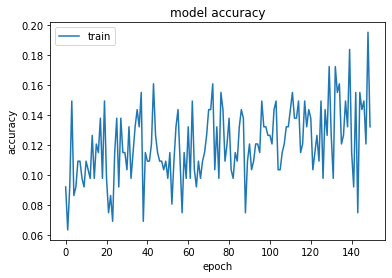

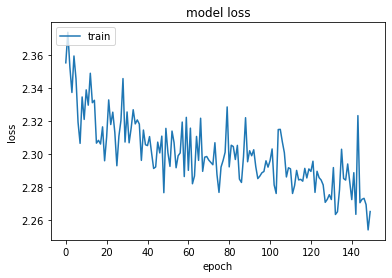

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 11 11:04:32 2020

@author: alessio
"""
"""""""""""""""""""""
150 epochs over_train dataset SGD optimization
"""


#classe=eval(input('inserisci lista delle classi da classificare'))
#traintestorvalid=input('train, test or valid:  ')
#frametype=input('over,rgb or simple:  ')
#x,y=generate_dataset(classe,traintestorvalid,frametype)

#187 is the total number of videos for the train set


classe=['help','pencil','fish','white','book','eat','red','milk','sad','nice']
input_shape=(22, 240, 320, 3)
n_classes=len(classe)
batch_size=2
epochs=150

model=action_model(input_shape,n_classes)
history=run_model(x,y,model,batch_size,epochs)

#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    # "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



## III SGD, 150 epochs, LSTM


(175, 22, 240, 320, 3)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
87/87 [==============================] - 79s 906ms/step - loss: 2.3188 - categorical_accuracy: 0.1207
Epoch 2/150
87/87 [==============================] - 80s 916ms/step - loss: 2.3407 - categorical_accuracy: 0.0977
Epoch 3/150
87/87 [==============================] - 80s 918ms/step - loss: 2.3274 - categorical_accuracy: 0.0862
Epoch 4/150
87/87 [==============================] - 80s 921ms/step - loss: 2.3008 - categorical_accuracy: 0.0862
Epoch 5/150
87/87 [==============================] - 80s 918ms/step - loss: 2.3248 - categorical_accuracy: 0.0690
Epoch 6/150
87/87 [==============================] - 80s 916ms/step - loss: 2.3099 - categorical_accuracy: 0.1207
Epoch 7/150
87/87 [==============================] - 80s 917ms/step - loss: 2.3142 - categorical_accuracy: 0.1149
Epoch 8/150
87/87 [==============================] - 80s 918ms/step - loss: 2.3221 - categorical_accura

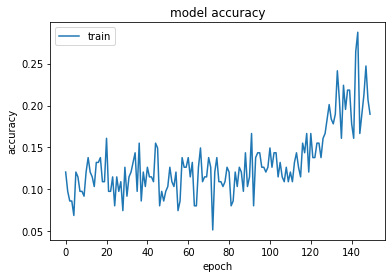

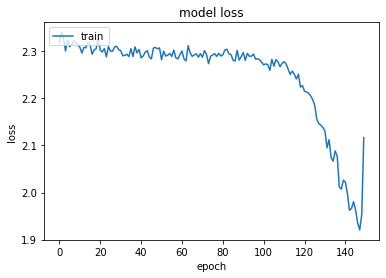

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 11 11:04:32 2020

@author: alessio
"""


#classe=eval(input('inserisci lista delle classi da classificare'))
#traintestorvalid=input('train, test or valid:  ')
#frametype=input('over,rgb or simple:  ')
#x,y=generate_dataset(classe,traintestorvalid,frametype)

#187 is the total number of videos for the train set


classe=['help','pencil','fish','white','book','eat','red','milk','sad','nice']
input_shape=(22, 240, 320, 3)
n_classes=len(classe)
batch_size=2
epochs=150

model=action_model(input_shape,n_classes)
history=run_model(x,y,model,batch_size,epochs)

#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    # "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



## IV SGD(lr=0.001),300 epochs, LSTM


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 11 11:04:32 2020

@author: alessio
"""


#classe=eval(input('inserisci lista delle classi da classificare'))
#traintestorvalid=input('train, test or valid:  ')
#frametype=input('over,rgb or simple:  ')
#x,y=generate_dataset(classe,traintestorvalid,frametype)

#187 is the total number of videos for the train set


classe=['help','pencil','fish','white','book','eat','red','milk','sad','nice']
input_shape=(22, 240, 320, 3)
n_classes=len(classe)
batch_size=2
epochs=200

model=action_model(input_shape,n_classes)
history=run_model(x,y,model,batch_size,epochs)

#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    # "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



NameError: ignored

## V test with validation

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 11 11:04:32 2020

@author: alessio
"""


#classe=eval(input('inserisci lista delle classi da classificare'))
#traintestorvalid=input('train, test or valid:  ')
#frametype=input('over,rgb or simple:  ')
#x,y=generate_dataset(classe,traintestorvalid,frametype)

#187 is the total number of videos for the train set


classe=['help','pencil','fish','white','book','eat','red','milk','sad','nice']
input_shape=(22, 240, 320, 3)
n_classes=len(classe)
batch_size=2
epochs=200

model=action_model(input_shape,n_classes)
history=run_model(x,y,model,batch_size,epochs)

#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


(180, 22, 240, 320, 3)
Epoch 1/200
90/90 [==============================] - 108s 1s/step - loss: 2.3807 - categorical_accuracy: 0.1000 - val_loss: 2.3192 - val_categorical_accuracy: 0.0333
Epoch 2/200
90/90 [==============================] - 107s 1s/step - loss: 2.3732 - categorical_accuracy: 0.1000 - val_loss: 2.3190 - val_categorical_accuracy: 0.0000e+00
Epoch 3/200
90/90 [==============================] - 107s 1s/step - loss: 2.3710 - categorical_accuracy: 0.0833 - val_loss: 2.2936 - val_categorical_accuracy: 0.2000
Epoch 4/200
90/90 [==============================] - 107s 1s/step - loss: 2.3752 - categorical_accuracy: 0.0889 - val_loss: 2.3036 - val_categorical_accuracy: 0.1333
Epoch 5/200
90/90 [==============================] - 107s 1s/step - loss: 2.3639 - categorical_accuracy: 0.0889 - val_loss: 2.2891 - val_categorical_accuracy: 0.2056
Epoch 6/200
90/90 [==============================] - 107s 1s/step - loss: 2.3301 - categorical_accuracy: 0.1056 - val_loss: 2.2865 - val_catego

In [ ]:
s=np.asarray([[1,2,3],[4,5,6],[7,8,9]])
z=np.asarray([[[1,1,1],[2,2,2],[3,3,3]],[[4,4,4],[5,5,5],[6,6,6]],[[7,7,7],[8,8,8],[9,9,9]]])
print(s)
print(z)
np.random.seed(9)
np.random.shuffle(s)
np.random.seed(9)
np.random.shuffle(z)

print(s)
print(z)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[4 4 4]
  [5 5 5]
  [6 6 6]]

 [[7 7 7]
  [8 8 8]
  [9 9 9]]]
[[4 5 6]
 [1 2 3]
 [7 8 9]]
[[[4 4 4]
  [5 5 5]
  [6 6 6]]

 [[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[7 7 7]
  [8 8 8]
  [9 9 9]]]
